In [1]:
#IMPORTS
import cv2 
import csv
import tqdm
import os
import sys
import pickle
import numpy as np
import mediapipe as mp 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
#LOADING MODEL
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5)

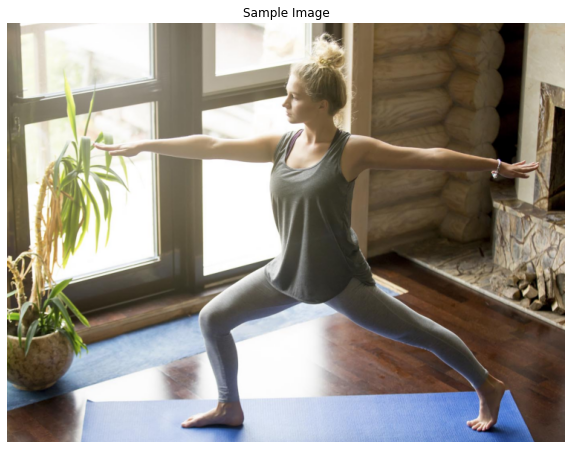

In [3]:
#PLOTTING SAMPLE IMAGE
image = cv2.imread('sample.png')
plt.figure(figsize = [10, 10])
plt.title("Sample Image")
plt.axis('off')
plt.imshow(image[:,:,::-1])
plt.show()

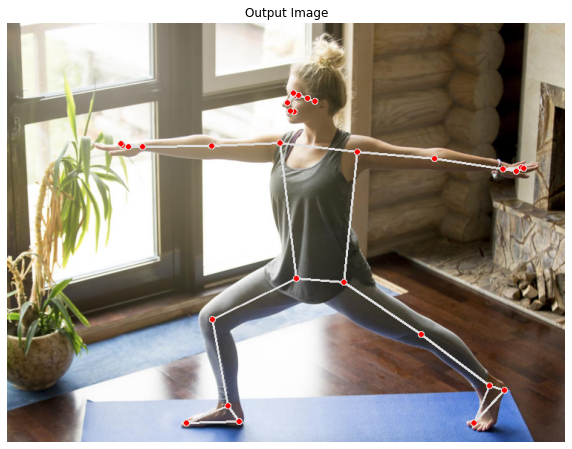

In [4]:
#DETECTING LANDMARKS IN SAMPLE IMAGE
results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
img_copy = image.copy()
if results.pose_landmarks:
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    plt.figure(figsize = [10, 10])
    plt.title("Output Image")
    plt.axis('off')
    plt.imshow(img_copy[:,:,::-1])
    plt.show()

In [11]:
#LANDMARKS
results.pose_landmarks

landmark {
  x: 0.5032970905303955
  y: 0.19192537665367126
  z: -0.175428107380867
  visibility: 0.9999896287918091
}
landmark {
  x: 0.5141446590423584
  y: 0.1735571324825287
  z: -0.18769709765911102
  visibility: 0.9999496936798096
}
landmark {
  x: 0.5179388523101807
  y: 0.17443084716796875
  z: -0.1880306899547577
  visibility: 0.999958872795105
}
landmark {
  x: 0.5231014490127563
  y: 0.17513403296470642
  z: -0.18789182603359222
  visibility: 0.999946117401123
}
landmark {
  x: 0.5114233493804932
  y: 0.17129278182983398
  z: -0.15863968431949615
  visibility: 0.9999603033065796
}
landmark {
  x: 0.5121729373931885
  y: 0.17056703567504883
  z: -0.15911906957626343
  visibility: 0.9999756813049316
}
landmark {
  x: 0.5127929449081421
  y: 0.1696387231349945
  z: -0.1592961847782135
  visibility: 0.9999693632125854
}
landmark {
  x: 0.5525026917457581
  y: 0.18816256523132324
  z: -0.18941205739974976
  visibility: 0.9999831914901733
}
landmark {
  x: 0.5383509397506714
  y: 

In [12]:
#TOTAL LANDMARKS
num_coords=len(results.pose_landmarks.landmark)
print(num_coords)

33


In [7]:
#MAKING FIRST COLUMN
landmarks = ['Class']
for val in range(1, num_coords+1):
    landmarks += ['X{}'.format(val), 'Y{}'.format(val), 'Z{}'.format(val)]

In [33]:
#INSERTING FIRST COLUMN
with open('coords.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [34]:
#PATHS
images_in_folder = 'Clean_dataset'
csv_out_path = 'coords.csv'
class_names = ["Down Dog","Goddess","Plank","Tree","Warrior II"]
folder_names = ["downdog","goddess","plank","tree","warrior2"]

In [35]:
#FUNCTION TO INSERT LANDMARKS IN CSV
def getcoords(class_name,images_in_folder):    
    image_names = [n for n in os.listdir(images_in_folder) if not n.startswith('.')]
    print('Inserting Data in CSV of class',class_name, file=sys.stderr)
    for image_name in tqdm.tqdm(image_names, position=0):
        input_frame = cv2.imread(os.path.join(images_in_folder,image_name))
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
        result = pose.process(image=input_frame)
        try:
            pose_landmarks = result.pose_landmarks.landmark
            row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in pose_landmarks]).flatten())
            row.insert(0, class_name)
            with open('coords.csv', mode='a', newline='') as f:
                csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                csv_writer.writerow(row) 
        except:
            pass

In [36]:
#INSERTING LANDMARKS IN CSV
for i in range(len(class_names)):
    getcoords(class_names[i],os.path.join(images_in_folder,folder_names[i]))

Inserting Data in CSV of class Down Dog
100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:30<00:00,  8.00it/s]
Inserting Data in CSV of class Goddess
100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:16<00:00,  7.50it/s]
Inserting Data in CSV of class Plank
100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:17<00:00,  7.52it/s]
Inserting Data in CSV of class Tree
100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [00:22<00:00,  6.77it/s]
Inserting Data in CSV of class Warrior II
100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:36<00:00,  7.31it/s]


In [37]:
#READING DATA FROM CSV
df = pd.read_csv('coords.csv')
df.shape

(887, 100)

In [38]:
#STORING FEATURES AND TARGET VALUE
df_copy=df.copy(deep=True)
X = df_copy.drop('Class', axis=1)
y = df_copy['Class'] 

In [39]:
#SPLITTING DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
#MAKING PIPELINES
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=5000)),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
    'kn':make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
}

In [41]:
#FITTING MODEL
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

In [42]:
#MODELS
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression(max_iter=5000))]),
 'rc': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridgeclassifier', RidgeClassifier())]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'gb': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingclassifier', GradientBoostingClassifier())]),
 'kn': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier())])}

In [43]:
#EVALUATING MODELS
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo,':',accuracy_score(y_test, yhat))

lr : 0.9887640449438202
rc : 0.9812734082397003
rf : 0.9737827715355806
gb : 0.9887640449438202
kn : 0.9325842696629213


In [44]:
#STORING BEST MODEL
with open('detect_pose.pkl', 'wb') as f:
    pickle.dump(fit_models['gb'], f)

In [8]:
#LOADING MODEL
with open('..\detect_pose.pkl', 'rb') as f:
    model = pickle.load(f)

c:\Users\pulki\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\pulki\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\pulki\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid r

In [7]:
#FUNCTION TO MAKE DETECTION USING IMAGE
def make_detections(image):
    input_frame = cv2.imread(image)
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    result = pose.process(image=input_frame)
    output_image = input_frame.copy()
    label = "Unknown Pose"
    accuracy = 0
    mp_drawing.draw_landmarks(image=output_image, landmark_list=result.pose_landmarks, 
                                  connections=mp_pose.POSE_CONNECTIONS)
    pose_landmarks = result.pose_landmarks.landmark
    row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in pose_landmarks]).flatten())
    X = pd.DataFrame([row])
    label = model.predict(X)[0]
    body_language_prob = model.predict_proba(X)[0]
    accuracy = str(round(body_language_prob[np.argmax(body_language_prob)]*100,3))
    if(float(accuracy)<50):
        label = "Unknown Pose"
    return label,accuracy,output_image

In [15]:
#OUTPUT
def output(lab,acc,out):
    plt.figure(figsize = [10, 10])
    if(lab=="Unknown Pose"):
        plt.title(lab)
    else:
        plt.title(f"Pose: {lab} | Accuracy: {acc}%")
    plt.axis('off')
    plt.imshow(out)
    plt.show()

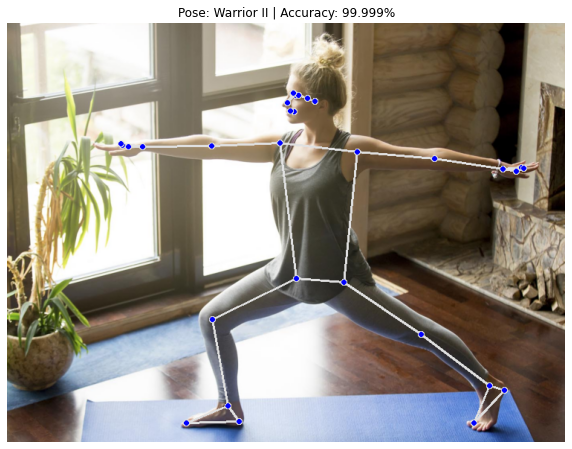

In [16]:
#PREDICTION
lab,acc,out=make_detections('sample.png')
output(lab,acc,out)

In [5]:
#FUNCTION TO MAKE DETECTION USING VIDEO
def make_detections_video(path):
    cap = cv2.VideoCapture('plank.mp4')
#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,360))
    if (cap.isOpened()==False): 
        print("Error opening video stream or file")
    while(cap.isOpened()):
        ret, frame = cap.read()
        input_frame = frame
        result = pose.process(image=input_frame)
        label = "Unknown Pose"
        accuracy = '0'
        mp_drawing.draw_landmarks(image=input_frame, landmark_list=result.pose_landmarks, 
                                          connections=mp_pose.POSE_CONNECTIONS)
        try:
            pose_landmarks = result.pose_landmarks.landmark
            row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in pose_landmarks]).flatten())
            X = pd.DataFrame([row])
            label = model.predict(X)[0]
            body_language_prob = model.predict_proba(X)[0]
            accuracy = str(round(body_language_prob[np.argmax(body_language_prob)]*100,3))
            if(float(accuracy)<50):
                label = "Unknown Pose"
        except:
            pass
        cv2.rectangle(input_frame, (0,0), (250, 60), (0, 0, 255), 1,cv2.LINE_4)
        cv2.putText(input_frame, 'Class'
                    , (5,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1,cv2.LINE_4)
        cv2.putText(input_frame, label
                    , (5,40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,cv2.LINE_4)
        cv2.putText(input_frame, 'Accuracy'
                    , (150,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1,cv2.LINE_4)
        cv2.putText(input_frame, accuracy
                    , (150,40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,cv2.LINE_4)
#         out.write(input_frame)
        cv2.imshow('Frame',input_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break  
    cap.release()
#     out.release()
    cv2.destroyAllWindows() 

In [6]:

make_detections_video('plank.mp4')